In [1]:
import tensorflow as tf
import json
from os import getcwd
import urllib
import numpy as np
import os
from keras_preprocessing.image import ImageDataGenerator

In [2]:
train_dir = os.path.join("plant_dataset/train")
test_dir = os.path.join("plant_dataset/test")

In [3]:
import matplotlib.pyplot as plt

In [4]:
# Data Augmentation

# Global Variables

IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
train_data_size = 22279
test_data_size = 5569


train_data = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 0.2,
                vertical_flip=True,
                fill_mode='nearest'
)


test_data = ImageDataGenerator(
                rescale = 1./255
)



train_set = train_data.flow_from_directory(
                train_dir,
                target_size=(IMG_WIDTH,IMG_HEIGHT),
                batch_size=BATCH_SIZE,
                class_mode = 'categorical'
)



test_set = test_data.flow_from_directory(
                test_dir,
                target_size = (IMG_WIDTH,IMG_HEIGHT),
                batch_size = BATCH_SIZE,
                shuffle=False,
                class_mode = 'categorical'
)

Found 22279 images belonging to 12 classes.
Found 5569 images belonging to 12 classes.


In [5]:
labels_values,no_of_images = np.unique(train_set.classes,return_counts = True)
dict(zip(train_set.class_indices,no_of_images))

{'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 1642,
 'Corn_(maize)___Common_rust_': 1907,
 'Corn_(maize)___Northern_Leaf_Blight': 1908,
 'Corn_(maize)___healthy': 1859,
 'Potato___Early_blight': 1939,
 'Potato___Late_blight': 1939,
 'Potato___healthy': 1824,
 'Tomato___Bacterial_spot': 1702,
 'Tomato___Leaf_Mold': 1882,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 1961,
 'Tomato___Tomato_mosaic_virus': 1790,
 'Tomato___healthy': 1926}

In [6]:
labels = test_set.class_indices
labels = { v:k for k,v in labels.items() }
values_lbl = list(labels.values()) 

In [7]:
dense = tf.keras.layers.Dense
conv = tf.keras.layers.Conv2D
max_pooling = tf.keras.layers.MaxPooling2D
flatten = tf.keras.layers.Flatten()
dropout = tf.keras.layers.Dropout(0.2)

In [8]:
# Sequential Model
model = tf.keras.Sequential()
# 1st layer
model.add(conv(16,(3,3),input_shape = (IMG_WIDTH,IMG_HEIGHT,3),padding='same',activation='relu'))
model.add(max_pooling(2,2))
# 2nd Layer
model.add(conv(32,(3,3),padding='same',activation='relu'))
model.add(max_pooling(2,2))
# Flatten Layer
model.add(flatten)
# 1st Hidden Layer
model.add(dense(512,activation='relu',))
model.add(dropout)
# 2nd Hidden Layer
model.add(dense(256,activation='relu'))
# Output Layer
model.add(dense(12,activation='softmax'))

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [9]:
# Compiling model 
model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.RMSprop(lr = 0.001),metrics=['acc'] )

In [10]:
history_model = model.fit_generator(train_set,steps_per_epoch = train_data_size // BATCH_SIZE+1,epochs=16,
                                    validation_data=test_set,validation_steps = test_data_size // BATCH_SIZE+1,verbose=1,
                                   callbacks = [
                                       tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 5)
                                   ])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/16
697/697 [==============================] - 1471s 2s/step - loss: 0.7562 - acc: 0.7817 - val_loss: 0.2180 - val_acc: 0.9310
Epoch 2/16
697/697 [==============================] - 1296s 2s/step - loss: 0.2422 - acc: 0.9211 - val_loss: 0.1601 - val_acc: 0.9445
Epoch 3/16
697/697 [==============================] - 1213s 2s/step - loss: 0.1931 - acc: 0.9421 - val_loss: 0.1906 - val_acc: 0.9447
Epoch 4/16
697/697 [==============================] - 1196s 2s/step - loss: 0.1643 - acc: 0.9531 - val_loss: 0.1138 - val_acc: 0.9607
Epoch 5/16
697/697 [==============================] - 1218s 2s/step - loss: 0.1565 - acc: 0.9585 - val_loss: 0.1256 - val_acc: 0.9605
Epoch 6/16
697/697 [==============================] - 1935s 3s/step - loss: 0.1437 - acc: 0.9637 - val_loss: 0.1528 - val_acc: 0.9553
Epoch 7/16
697/697 [==============================] - 1263s 2s/step - loss: 0.1506 - acc: 0.9644 - val_loss: 0.1112 - va

In [11]:
model.save("first_one.h5")

In [12]:
f_model = tf.keras.models.load_model("first_one.h5")

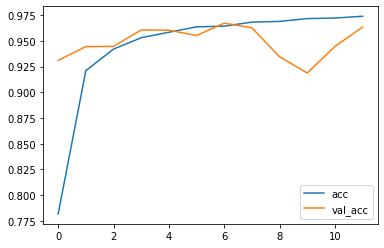

In [16]:
# Accuracy comparison
plt.plot(history_model.history['acc'])
plt.plot(history_model.history['val_acc'])
plt.legend(['acc','val_acc'])
plt.show()

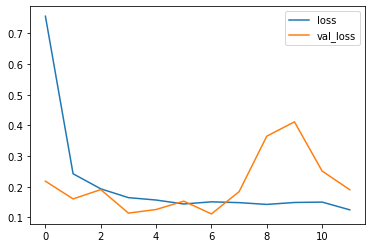

In [17]:
# Loss Comparison

plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [18]:
from sklearn.metrics import classification_report,confusion_matrix

In [23]:
y_test = test_set.classes

In [28]:
pred = f_model.predict_generator(test_set,test_data_size//BATCH_SIZE+1,verbose=1,).argmax(axis=1)

175/175 [==============================] - 51s 294ms/step


In [36]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.94      0.87      0.91       410
           1       1.00      0.99      0.99       477
           2       0.90      0.95      0.92       477
           3       1.00      1.00      1.00       465
           4       0.93      1.00      0.96       485
           5       0.95      0.94      0.94       485
           6       1.00      0.93      0.96       456
           7       0.95      0.98      0.97       425
           8       0.98      0.95      0.97       470
           9       0.99      0.96      0.98       490
          10       0.98      0.98      0.98       448
          11       0.95      1.00      0.97       481

    accuracy                           0.96      5569
   macro avg       0.96      0.96      0.96      5569
weighted avg       0.96      0.96      0.96      5569



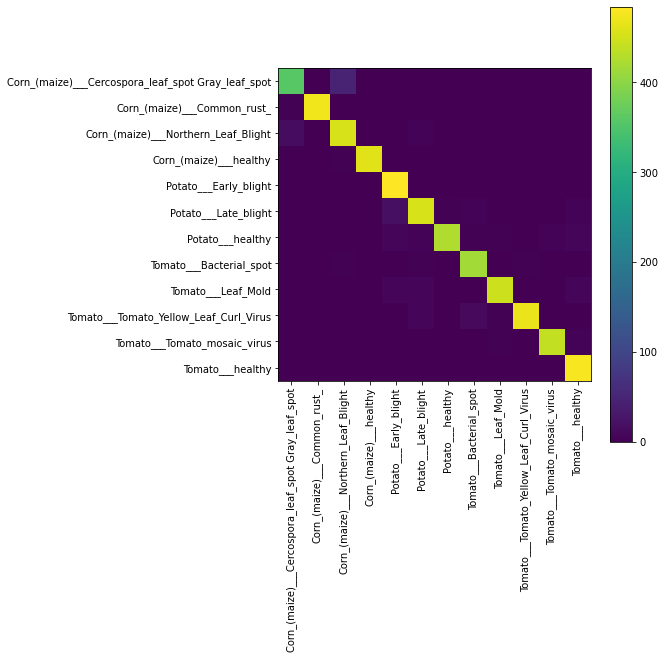

In [34]:
conf = confusion_matrix(y_test,pred)
plt.figure(figsize=(7,8))
plt.imshow(conf, interpolation='nearest')
plt.colorbar()
plot_mark = np.arange(len(values_lbl))
_ = plt.xticks(plot_mark, values_lbl, rotation=90)
_ = plt.yticks(plot_mark, values_lbl)

In [38]:
total_count=0
for i in range(len(y_test)):
    if y_test[i] != pred[i]:
        total_count += 1
print('Total number of test cases', ((len(y_test))))
print('Number of wrong predictions', total_count)

Total number of test cases 5569
Number of wrong predictions 203


In [67]:
from keras.preprocessing import image

Using TensorFlow backend.


In [141]:
img = image.load_img('test/test/TomatoYellowCurlVirus5.jpg',target_size=(224,224,3))
img = image.img_to_array(img)
img = img/255

Label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Accuracy: 99.95583891868591


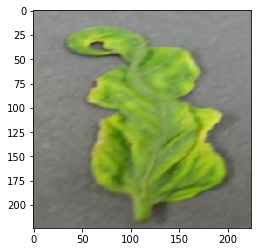

In [156]:
proba = f_model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(1):
    print("Label: {}".format(labels[top_3[i]]))
    print("Accuracy: {:2}".format(proba[0][top_3[i]]*100))
plt.imshow(img)